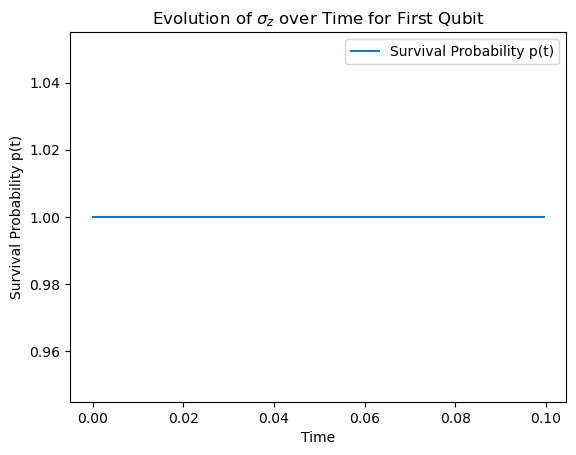

In [1]:
from qiskit import QuantumCircuit, Aer, execute, transpile
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import matplotlib.pyplot as plt
# Time parameters
dt = 0.0005  # Time step for the simulation
time_steps = 200  # Total number of time steps for the simulation

N = 4 #qubits 
J_ij = 1/(N-1)  # Interaction strength, assuming a constant value for simplicity
# Backend selection for simulation
backend = Aer.get_backend('aer_simulator')
shots = 1024

# Function to create the quantum circuit with specific alpha value
def create_circuit(dt,alpha_value):
    qc = QuantumCircuit(N, N)  # Adjusted for 4 qubits and classical bits
    # alpha_value = dt * J_ij  # This might be recalculated for each pair or step if needed
    # Initialize the first N/2 qubits to spin down (|1>) and the rest to spin up (|0>)
    for i in range(N//2):
        qc.x(i)  # Apply Pauli-X gate to flip the first N/2 qubits to |1>
    # Apply the RXX, RYY, and RZZ gates with theta = 2 * alpha across pairs of qubits
    # Assuming a linear chain or ring of qubits for interactions
    for i in range(N-1):  # Loop through the first to the second-to-last qubit
        for j in range(i+1, N):  # Loop from the next qubit to the last qubit
            # qc.rxx(2 * alpha_value, i, j)
            # qc.ryy(2 * alpha_value, i, j)
            # qc.rzz(2 * alpha_value, i, j)

    #         # qc.rxx(2 * alpha_value, 0, 1)
    #         # qc.ryy(2 * alpha_value, 0, 1)
    #         # qc.rzz(2 * alpha_value, 0, 1)
    #     # Additional interactions for a ring-like structure (optional, remove if not needed)
    #     # qc.rxx(2 * alpha_value, N, 0)
    #     # qc.ryy(2 * alpha_value, N, 0)
    #     # qc.rzz(2 * alpha_value, N, 0)
            
            qc.u(-pi/2, 0, 0, i)

            # Apply the RZZ gate to generate the ZZ gate in the paper with theta = pi/2
            qc.rzz(pi/2, 0, j)

            # Apply the Uq gate with U(θ,ϕ,λ) to both qubits.
            # where Uq gate on first qubit with theta = pi/2, phi = pi 
            # equivalent u gate in qiskit with theta = pi/2, phi = pi/2, lambda = -pi/2
            qc.u(pi/2, pi/2, -pi/2, i)
            # and on second quibit is theta = 2*alpha, phi = pi/2
            # equivalent u gate in qiskit with theta = 2*alpha, phi = 0, lambda = 0 
            qc.u(2*alpha_value, 0, 0, j)

            # Apply the Rz gate with lambda = 2*alpha - 3*pi/2 to first qubit and lambda = - 3*pi/2 to the second.
            qc.rz(2*alpha_value - 3*pi/2, i)
            qc.rz(-3*pi/2, j)

            # Apply the RZZ gate with theta = pi/2
            qc.rzz(pi/2, 0, j)

            # Apply the Uq gate with theta = -pi/2 and phi = pi/2 to first qubit. 
            # equivalent u gate in qiskit with theta = -pi/2, phi = 0, lambda = 0 
            qc.u(-pi/2, 0, 0, i)
            # and on second quibit is theta = 2*alpha, phi = pi/2
            # equivalent u gate in qiskit with theta = 2*alpha, phi = 0, lambda = 0 
            qc.u(2*alpha_value, 0, 0, j)

            # Apply the Rz gate with lambda = -pi/2 to second qubit.
            qc.rz(-pi/2, j)

            # Apply the RZZ gate with theta = pi/2
            qc.rzz(pi/2, 0, j)

            # Apply the Uq gate with theta = pi/2 and phi = pi to first qubit.
            # equivalent u gate in qiskit with theta = pi/2, phi = pi/2, lambda = -pi/2
            qc.u(pi/2, pi/2, -pi/2, i)
        


    # Measure in the computational basis
    qc.measure(range(N), range(N))
    
    return qc

# Simulation and expectation value calculation
sigma_z_values = []
survival_probabilities = []  # List to store survival probabilities

for step in range(time_steps):
    t = dt * step
    # Calculate alpha for the current time step
    alpha_value = dt * J_ij 
    
    # Create and execute the circuit with the current alpha value
    qc = create_circuit(dt,alpha_value)
    transpiled_qc = transpile(qc, backend)
    result = execute(transpiled_qc, backend, shots=shots).result()
    counts = result.get_counts(qc)
    
    # Calculate expectation value of sigma_z for this step
    sigma_z = 0
    # for outcome in counts:
    #     # Convert the outcome to sigma_z contributions
    #     sigma_z_contribution = sum([1 if bit == '0' else -1 for bit in outcome]) / (N-1)  # Adjusted for 4 qubits
    #     sigma_z += sigma_z_contribution * counts[outcome] / shots
    # sigma_z_values.append(sigma_z)
    for outcome in counts:
    # Convert the outcome to sigma_z contribution for the first qubit
    # Qiskit orders qubits in reverse; qubit 0 is the rightmost bit
        if outcome[::-1][0] == '0':  # Check the state of the first qubit
            sigma_z += counts[outcome] / shots
        else:
            sigma_z -= counts[outcome] / shots
    
    # Store the calculated value
    sigma_z_values.append(sigma_z)
    # Calculate survival probability and append to the list
    survival_probabilities.append((1 - sigma_z) / 2)
# Plotting the evolution of sigma_z over time
time_array = np.arange(0, time_steps*dt, dt)
plt.plot(time_array, survival_probabilities, label='Survival Probability p(t)')
plt.xlabel('Time')
plt.ylabel('Survival Probability p(t)')
plt.title('Evolution of $\\sigma_z$ over Time for First Qubit')
plt.legend()
plt.show()
